In [1]:
import os
import cv2
import torch
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
# Ensure that plots are displayed inline in Jupyter Notebook
%matplotlib inline

In [3]:
# ============================
# Step 1: Load the YOLOv8 Model
# ============================

model_variant = 'yolov8l.pt'  # Change to other variants if needed

# Load the YOLOv8 model
try:
    model = YOLO(model_variant)
    print(f"YOLOv8 '{model_variant}' model loaded successfully.")
except Exception as e:
    print(f"Error loading YOLOv8 model: {e}")

YOLOv8 'yolo11n.pt' model loaded successfully.


In [10]:
# results = model.train(
#     data="dataset/data.yaml",
#     epochs=50,        # tweak as needed
#     imgsz=640,
#     batch=16,         # reduce if you run OOM
#     workers=2         # often safer in notebooks
# )

Ultralytics 8.3.231 🚀 Python-3.12.11 torch-2.9.1 CPU (Apple M4 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, prof

In [11]:
model = YOLO("runs/detect/train2/weights/best.pt")

In [12]:
# ============================
# Step 2: Define the Inventory Detection Function
# ============================

def detect_inventory(image_path, confidence_threshold=0.3, iou_threshold=0.5):
    """
    Detects inventory items in the given image using YOLOv8 and returns a DataFrame.

    Args:
        image_path (str): Path to the input image.
        confidence_threshold (float): Minimum confidence score to consider a detection.
        iou_threshold (float): IOU threshold for Non-Max Suppression.

    Returns:
        inventory_df (DataFrame): Detected inventory with item name and count.
        results (list): YOLOv8 inference results.
    """
    print(f"\nProcessing image for inventory detection: {image_path}")

    # Verify that the image exists
    if not os.path.exists(image_path):
        print(f"Error: Image not found at path: {image_path}")
        return pd.DataFrame(), None

    try:
        results = model.predict(
            source=image_path,
            conf=confidence_threshold,
            iou=iou_threshold,
            save=False,
            verbose=False
        )
    except Exception as e:
        print(f"Error during prediction: {e}")
        return pd.DataFrame(), None

    first_result = results[0] if results else None
    detections = first_result.boxes if first_result else None

    if detections is None or len(detections) == 0:
        print("No items detected in the image.")
        return pd.DataFrame(), results

    # Initialize an inventory list to store detected items
    inventory = []
    for box in detections:
        cls_id = int(box.cls)  # Class ID
        confidence = box.conf.item()  # Confidence score
        class_name = model.names[cls_id]  # Get class name from model's class names
        if confidence < confidence_threshold:
            continue
        inventory.append([class_name, confidence])

    # Create a DataFrame to store the inventory
    inventory_df = pd.DataFrame(inventory, columns=['Item', 'Confidence'])
    inventory_df['Count'] = 1
    inventory_df = inventory_df.groupby('Item').agg({'Count': 'sum', 'Confidence': 'mean'}).reset_index()

    print(f"Detected Inventory:\n{inventory_df}")
    return inventory_df, results

In [13]:
# ============================
# Step 3: Define the Function to Display Results with Bounding Boxes
# ============================

def display_results(image_path, results):
    """
    Displays the image with bounding boxes and labels using matplotlib.

    Args:
        image_path (str): Path to the input image.
        results (list): YOLOv8 inference results.
    """
    print(f"\nDisplaying results for image: {image_path}")

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image with OpenCV: {image_path}")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axis

    first_result = results[0] if results else None
    detections = first_result.boxes if first_result else None

    if detections is None or len(detections) == 0:
        print("No detections to display.")
        plt.show()
        return

    for box in detections:
        cls_id = int(box.cls)
        confidence = box.conf.item()
        class_name = model.names[cls_id]

        xyxy = box.xyxy.tolist()

        if isinstance(xyxy[0], list):
            xyxy = xyxy[0]

        x1, y1, x2, y2 = map(int, xyxy)
        label = f"{class_name} {confidence:.2f}"

        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                         fill=False, edgecolor='red', linewidth=2))
        plt.text(x1, y1 - 10, label, color='red', fontsize=12,
                 bbox=dict(facecolor='yellow', alpha=0.5))

    plt.show()


In [14]:
# ============================
# Step 4: UI Functions for Interacting with Inventory
# ============================

def save_inventory(inventory_df, filename="inventory.csv"):
    """Save the detected inventory to a CSV file."""
    if not inventory_df.empty:
        inventory_df.to_csv(filename, index=False)
        print(f"Inventory saved to {filename}")
    else:
        print("No inventory to save.")

def load_inventory(filename="inventory.csv"):
    """Load inventory from a CSV file."""
    if os.path.exists(filename):
        inventory_df = pd.read_csv(filename)
        print(f"Inventory loaded from {filename}")
        return inventory_df
    else:
        print(f"File {filename} not found.")
        return pd.DataFrame()

# UI Widgets for Saving/Loading/Displaying Inventory
def inventory_ui(inventory_df):
    """Create an interactive UI for inventory management."""
    output = widgets.Output()

    def on_save_clicked(b):
        with output:
            clear_output()
            save_inventory(inventory_df)

    def on_load_clicked(b):
        with output:
            clear_output()
            inventory_df = load_inventory()
            display(inventory_df)

    def on_display_clicked(b):
        with output:
            clear_output()
            if not inventory_df.empty:
                display(inventory_df)
            else:
                print("No inventory to display.")

    save_button = widgets.Button(description="Save Inventory")
    load_button = widgets.Button(description="Load Inventory")
    display_button = widgets.Button(description="Display Inventory")

    save_button.on_click(on_save_clicked)
    load_button.on_click(on_load_clicked)
    display_button.on_click(on_display_clicked)

    display(widgets.VBox([save_button, load_button, display_button, output]))


Checking image path: dataset/valid/images/0c35998a-7393-4fbf-bafb-bd4b7e64532a_JPG.rf.ebc904d632e19e6bb1c830c098b78968.jpg

Processing image for inventory detection: dataset/valid/images/0c35998a-7393-4fbf-bafb-bd4b7e64532a_JPG.rf.ebc904d632e19e6bb1c830c098b78968.jpg
Detected Inventory:
          Item  Count  Confidence
0      brinjal      1    0.837086
1      cabbage      1    0.895235
2     capsicum      1    0.878527
3  cauliflower      1    0.956963
4    coriander      1    0.912102
5     cucumber      1    0.894059
6       ginger      1    0.953906
7       tomato      1    0.925310



Displaying results for image: dataset/valid/images/0c35998a-7393-4fbf-bafb-bd4b7e64532a_JPG.rf.ebc904d632e19e6bb1c830c098b78968.jpg


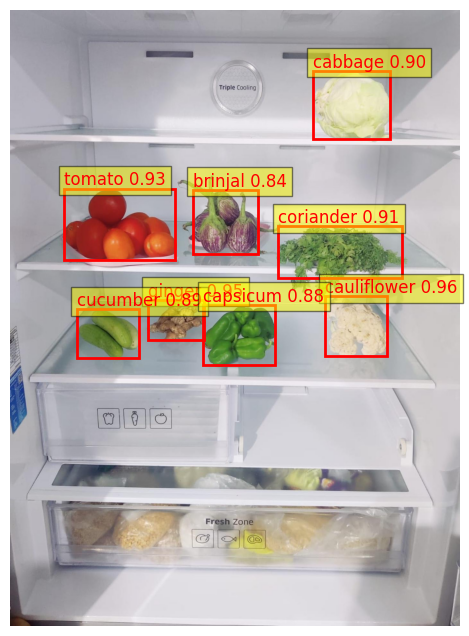

In [16]:
# ============================
# Step 5: Main Code - Detect Inventory and Use UI
# ============================

image_path = 'dataset/valid/images/0c35998a-7393-4fbf-bafb-bd4b7e64532a_JPG.rf.ebc904d632e19e6bb1c830c098b78968.jpg'  # Update with your image path
print(f"Checking image path: {image_path}")

inventory_df, results = detect_inventory(image_path)

# Display the inventory UI
inventory_ui(inventory_df)

# Show the image with detected bounding boxes
if results:
    display_results(image_path, results)
else:
    print("No results to display.")

In [8]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="22PryOpF5AGXVrv4cyMW")
# project = rf.workspace("ai-project-pji0a").project("ingredient-detection-5uzov")
# version = project.version(6)
# dataset = version.download("yolov8")

  Using cached python_dotenv-1.2.1-py3-none-any.whl.metadata (25 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 38.6 MB/s eta 0:00:0031m39.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.3/892.3 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 58.2 MB/s eta 0:00:00
Using cached python_dotenv-1.2.1-py3-none-any.whl (21 kB)
  Attempting uninstall: idna━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 4/8 [opencv-python-headless]
    Found existing installation: idna 3.10╺━━━━━━━━━━━━━━━━━━━ 4/8 [opencv-python-headless]
    Uninstalling idna-3.10:━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 4/8 [opencv-python-headless]
      Successfully uninstalled idna-3.10m╺━━━━━━━━━━━━━━━━━━━ 4/8 [opencv-python-headless]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [roboflow]━━ 7/8 [roboflow]-headless]
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Ingredient-Detection-6 in yolov8:: 100%|████████████████████████████████████████████████████████████████████████████████| 6524/6524 [00:01<00:00, 4427.11it/s]
